# Preprocessing
1. Convert text to lowercase 
2. Remove URLs, mentions, and special characters (besides hashtags and emojis)
3. Remove stop words
4. Perform stemming/lemmatization

In [1]:
import pandas as pd
import re
import spacy
from googletrans import Translator
import fasttext
import emoji

ModuleNotFoundError: No module named 'fasttext'

In [2]:
# Load the JSON file
df_posts = pd.read_json('../data/dataset.json')
df_posts.head()

,timestamp,text,text_id,user,user_id
0,2024-10-31,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936


Check for rows with no text

In [3]:
# Display rows where 'text' is missing (NaN)
missing_text_rows = df_posts[df_posts['text'].isnull()]
missing_text_rows

,timestamp,text,text_id,user,user_id


### Emojis

In [4]:
# Replace Unicode emoji with emoji name
def replace_emojis(text):
    return emoji.demojize(text, delimiters='')

# Remove all emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')


#df_posts['text'] = df_posts['text'].apply(replace_emojis)
df_posts['text'] = df_posts['text'].apply(remove_emojis)

### Convert variables

Copy hashtags to a new column 'hashtags'

In [5]:
# Apply regex to each row in the 'text' column to extract hashtags
df_posts['hashtags'] = df_posts['text'].apply(lambda x: re.findall(r'#\w+', x))

Copy mentions to a new column 'mentions'

In [6]:
# Extract mentions from the 'text' column, remove the '@' symbol, and create a new column 'mentions'
df_posts['mentions'] = df_posts['text'].apply(lambda x: [mention[1:] for mention in re.findall(r'@\w+', x)])

Remove Date from Timestamp

In [7]:
# All Dates are the same
unique_dates = df_posts['timestamp'].dt.date.unique()
unique_dates

array([datetime.date(2024, 10, 31)], dtype=object)

In [8]:
df_posts['timestamp'] = df_posts['timestamp'].dt.time
df_posts.head()

,timestamp,text,text_id,user,user_id,hashtags,mentions
0,00:00:00,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112,"[#HRtech, #businessmanagement]",[]
1,00:00:00,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430,[#politics],[]
2,00:00:00,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642,"[#Ukrainewashed, #WarPreparedness]",[]
3,00:00:00,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480,"[#FamilyTree, #GeneticFacts]",[]
4,00:00:00,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936,[#RationChorCongress],[]


Leave apostrophes in here for better lemmatization performance

In [9]:
# Some helper methods...

def lower(text):
  return text.lower() # Return lowercase

def remove_links(text):
  text = re.sub(r'http\S+', '', text) # remove http links
  text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
  text = text.replace('[link]', '') # remove [link]
  return text

def remove_hashtags(text):
  text = re.sub(r'#\w+', '', text)  # remove hashtags and following text
  return text.strip()

def remove_emails(text):
   text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
   return text.strip()

def remove_mentions(text):
   text = re.sub(r'@\w+', '', text) # remove mentions and following text
   return text.strip()

def remove_twitter_terms(text):
    remove_tw_terms = ["cc", "cx", "ct", "dm", "ht", "mt", "prt", "rt", "followback", "follow back", "fb", "retweet", "retweets"]
    remove_terms_pattern = re.compile(r'\b(' + '|'.join(re.escape(term) for term in remove_tw_terms) + r')\b', re.IGNORECASE)
    return remove_terms_pattern.sub('', text)

def remove_punctuation_and_numbers(text):
  text = re.sub(r"[^\w\s'’]", '', text)  # remove punctuation but keep apostrophes
  text = re.sub(r'\d+', '', text)  # remove numbers
  return text

# Function to merge spaced-out letters
def merge_letter_spacing(text):
    text = re.sub(r'(\b(?:\w\s)+\w\b)', lambda m: m.group(0).replace(' ', ''), text)
    return text

# Convert full-width characters to half-width
def normalize_full_width(text):
  return ''.join(
    chr(ord(char) - 0xFEE0) if 0xFF01 <= ord(char) <= 0xFF5E else char
    for char in text)

def remove_underscore(text):
  text = re.sub(r'([_]+)', '', text)
  return text

def remove_excessive_whitespace(text):
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [10]:
# Apply all above functions to our posts
df_posts['text'] = df_posts['text'].apply(lower)
df_posts['text'] = df_posts['text'].apply(remove_links)
df_posts['text'] = df_posts['text'].apply(remove_hashtags)
df_posts['text'] = df_posts['text'].apply(remove_emails)
df_posts['text'] = df_posts['text'].apply(remove_mentions)
df_posts['text'] = df_posts['text'].apply(remove_twitter_terms)
df_posts['text'] = df_posts['text'].apply(remove_punctuation_and_numbers)
df_posts['text'] = df_posts['text'].apply(merge_letter_spacing)
df_posts['text'] = df_posts['text'].apply(normalize_full_width)
df_posts['text'] = df_posts['text'].apply(remove_underscore)
df_posts['text'] = df_posts['text'].apply(remove_excessive_whitespace)

# Display head to check the results
df_posts[['text']].head(5)

,text
0,running a business means juggling countless ad...
1,liz truss is walking in the lingering shadow o...
2,the uk is bracing for war as government buildi...
3,marrying a second or third cousin once removed...
4,it's truly disgraceful how the indian national...


### Check for duplicates

In [11]:
# Total duplicate rows
total_duplicate_rows = df_posts['text'].duplicated(keep=False).sum()

# Number of unique duplicate tweets
unique_duplicate_tweets = (df_posts['text'].value_counts() > 1).sum()

print(f"Total duplicate rows: {total_duplicate_rows}")
print(f"Unique duplicate tweets: {unique_duplicate_tweets}")

Total duplicate rows: 40236
Unique duplicate tweets: 16404


### Duplicate stats

In [12]:
# Get the frequency distribution of tweets
frequency_distribution = df_posts['text'].value_counts()

# Filter for only duplicates (frequency > 1)
duplicate_tweet_frequencies = frequency_distribution[frequency_distribution > 1]

# Summary statistics
print(duplicate_tweet_frequencies.describe())

# How many tweets are repeated more than 5 times?
highly_duplicated = (duplicate_tweet_frequencies > 5).sum()
print(f"Number of tweets repeated more than 5 times: {highly_duplicated}")

count    16404.000000
mean         2.452816
std          2.184873
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        130.000000
Name: count, dtype: float64
Number of tweets repeated more than 5 times: 150


Remove duplicate tweets only if the same person posted the same tweet (spam) but extract frequency

In [13]:
# Step 1: Group by 'user' and 'text' and calculate the frequency of each combination
df_posts['frequency'] = df_posts.groupby(['user', 'text'])['text'].transform('count')

# Step 2: Drop duplicates based on 'user' and 'text' (keeping the first occurrence)
df_posts = df_posts.drop_duplicates(subset=['user', 'text'], keep='first').reset_index(drop=True)

## Different languages

In [14]:
# Load the pre-trained language identification model
model = fasttext.load_model('../models/lid.176.bin')

# Function to detect language using FastText
def detect_language_fasttext(text, threshold=0.8):
    # Skip tweets with fewer than 3 words
    if len(text.split()) < 3:
        return None  # Skip these tweets entirely
    try:
        predictions = model.predict(text)  # Predict the language
        lang_code = predictions[0][0].replace("__label__", "")  # Extract language code
        return lang_code
    except Exception as e:
        return None  # Skip on exception

# Apply language detection to the 'text' column
df_posts['language'] = df_posts['text'].apply(detect_language_fasttext)

# Filter non-English tweets (ignoring None values)
non_english_tweets = df_posts[(df_posts['language'].notna()) & (df_posts['language'] != 'en')]

# Filter to keep English tweets AND tweets with None language
df_posts = df_posts[(df_posts['language'] == 'en') | (df_posts['language'].isna())].copy()

# Print diagnostic information
print(f"Total tweets after filtering: {len(df_posts)}")
print(f"English tweets: {len(df_posts[df_posts['language'] == 'en'])}")
print(f"Tweets with None language: {df_posts['language'].isna().sum()}")
print(f"Number of non-English tweets: {len(non_english_tweets)}")

Total tweets after filtering: 67670
English tweets: 67389
Tweets with None language: 281
Number of non-English tweets: 865


In [15]:
# Save the non-English tweets to a CSV file
non_english_tweets.to_csv('../output/non_english_tweets.csv', index=False)

In [16]:
print(df_posts['language'].unique())

['en' None]


Count the number of appearances of each Language

In [17]:
language_counts = non_english_tweets['language'].value_counts()
print("Number of tweets per non-english language:")
language_counts

Number of tweets per non-english language:


language
pt     546
es     143
th      74
id      17
sw      11
de      10
tl       9
it       5
ko       4
ta       4
fr       3
ar       3
fi       3
pl       3
ms       3
tr       3
ja       2
ru       2
nap      2
bn       2
lt       2
ca       2
no       2
hi       2
nl       2
mr       1
uz       1
hu       1
sv       1
ml       1
la       1
Name: count, dtype: int64

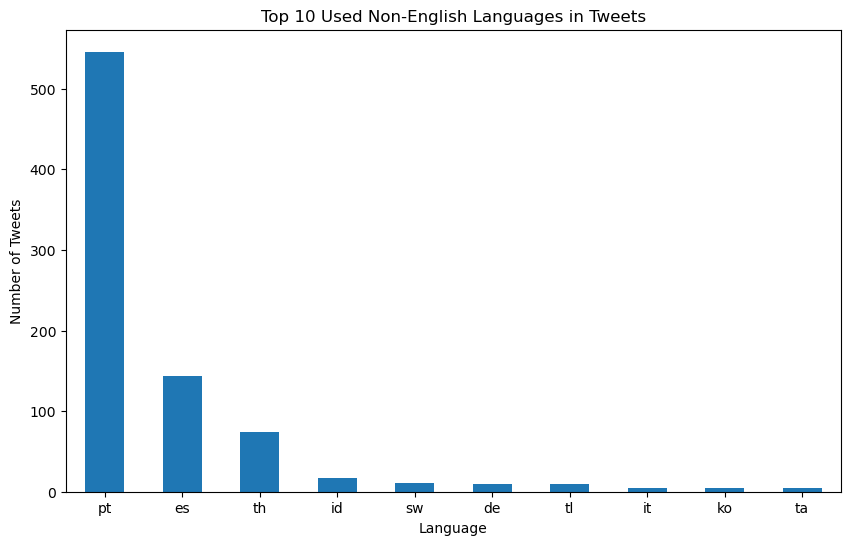

In [31]:
import matplotlib.pyplot as plt

# Get the top 10 languages excluding English
top_languages = language_counts.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
top_languages.plot(kind='bar')
plt.title('Top 10 Used Non-English Languages in Tweets')
plt.xlabel('Language')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.savefig('../figures/top-10-used-non-english-languages.png')
plt.show()

In [19]:
top_languages

language
en    67389
Name: count, dtype: int64

Translate the tweets

In [18]:
# Initialize translator
translator = Translator()
# Define languages to translate
languages_to_translate = ['PT', 'ES', 'TL']
# Filter tweets in the selected languages
translated_tweets = non_english_tweets[non_english_tweets['language'].isin(languages_to_translate)].copy()

# Function to translate text
def translate_text(text):
    try:
        result = translator.translate(text, dest='en')
        return result.text
    except Exception as e:
        return text  # Return original text if translation fails

# Translate all tweets
translated_tweets['text'] = translated_tweets['text'].apply(translate_text)

# Save to CSV
translated_tweets.to_csv('../output/translated_tweets.csv', index=False)
print(f"Number of tweets translated: {len(translated_tweets)}")

Number of tweets translated: 0


Append translated tweets to english tweets dataframe

In [19]:
df_posts = pd.concat([df_posts, translated_tweets], ignore_index=True)

print(f"Final number of tweets: {len(df_posts)}")

Final number of tweets: 67670


In [20]:
# Remove non_ascii characters after translation, because of e.g. chinese characters

def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128)

df_posts['text'] = df_posts['text'].apply(remove_non_ascii)

Export before lemmatization and removing stopwords, for other analysis

In [21]:
df_posts.to_csv('../output/export_without_spacy.csv', index=False)

## Use spacy

Download the spaCy model
Can be installed via `python -m spacy download en_core_web_sm`

In [22]:
# Load en_core_web_sm for spacy
nlp = spacy.load("en_core_web_sm")

### Lemmatization

Use lemmatization since stemming can lead to less accurate results (even non-words)

In [23]:
# Info this takes about 4.5m!!
df_posts['text'] = df_posts['text'].apply(
        lambda text: ' '.join([token.lemma_ for token in nlp(text)])
)

### Check again for empty rows

In [24]:
# Display rows where 'text' is missing (NaN) or ''
missing_text_rows = df_posts[df_posts['text'].isnull() | df_posts['text'].str.strip().eq('')]
missing_text_rows.head()

,timestamp,text,text_id,user,user_id,hashtags,mentions,frequency,language
6651,01:54:20,,2063227611,hmcpherson,1013503850,"[#GoodVibesOnly, #FunTimes, #LaughTogether]","[jessicagarcia, jkelly, sarahwest, alexanderpe...",1,None
7094,02:01:08,,2047300465,christopherwillis,1001624675,[#BeachDayBliss],"[elopez, dgutierrez, cabrerachristine, xstone,...",3,None
7321,02:04:38,,2077837206,ogonzalez,1014617157,"[#GoodTimes, #AdventureAwaits, #ExploreTheWorld]","[vclark, mfitzpatrick, katherine79, ppowell, s...",1,None
7843,02:13:21,,2022793964,rachel32,1056527098,"[#Innovation, #TechTalk, #AIRevolution, #Futur...","[gail92, sarahvillanueva, summermartin, derekc...",1,None
8546,02:24:53,,2059348333,wsantos,1074821018,[],"[itaylor, ricardo04, aaronhampton, timothywrig...",2,None


In [25]:
len(missing_text_rows)

56

In [26]:
# Remove empty posts only for SA
# df_posts = df_posts[~df_posts['text'].isnull() & df_posts['text'].str.strip().ne('')]

Remove stopwords

In [27]:
df_posts['text'] = df_posts['text'].fillna('').apply(
    lambda text: ' '.join([token.text for token in nlp.make_doc(text) if not token.is_stop])
)

Remove Apostrophes

In [28]:
df_posts['text'] = df_posts['text'].str.replace(r"[’']", "", regex=True)

### Write the output to csv file

In [29]:
df_posts.to_csv('../output/preprocessed.csv', index=False)

In [30]:
# Info this can take over 30m!!
# spacy.prefer_gpu()  # Prefers GPU but doesn't crash if unavailable
# nlp = spacy.load("en_core_web_trf")
# def extract_entities(text):
#     """
#     Extracts named entities from text using SpaCy's NER model.

#     Args:
#     text (str): The text from which to extract named entities.

#     Returns:
#     list: A list of tuples where each tuple contains (entity_text, entity_label).
#     """
#     if not text or pd.isna(text):
#         return []  # Return an empty list if text is missing

#     # Process text with SpaCy
#     doc = nlp(text)

#     # Extract entity text and labels
#     entities = [(ent.text, ent.label_) for ent in doc.ents]

#     return entities

# def preprocess_text(text):
#     """
#     Preprocesses text by removing URLs and emojis while keeping mentions and hashtags intact.

#     Args:
#     text (str): The original text.

#     Returns:
#     str: Preprocessed text.
#     """
#     if not text or pd.isna(text):
#         return ""  # Return empty string if text is missing

#     # Remove URLs
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text)
#     # Remove emojis
#     text = emoji.replace_emoji(text, replace="")
    
#     return text.strip()

# # Create a preprocessed text column
# df_posts['preprocessed_text'] = df_posts['text'].apply(preprocess_text)

# # Apply NER extraction on the preprocessed text
# df_posts['entities'] = df_posts['preprocessed_text'].apply(extract_entities)